In [1]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn.functional import conv2d
import numpy as np

from torch.utils.data import Dataset, DataLoader

device = 'cuda'

In [2]:
class reconstruct_CNN(nn.Module):
    def __init__(self, num_neuron):
        super().__init__()
        modules = []

        hidden_dims = [16, 64, 128, 64, 16]

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=5,
                               stride=1,
                               padding=2,
                               output_padding=2,
                               dilation=5),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1,
                      kernel_size=3, padding=1),
            nn.Tanh())

        self.layers = nn.Sequential(*modules)
        self.linear_input = nn.Linear(num_neuron, hidden_dims[0] * 4)

    def forward(self, x):
        x = self.linear_input(x)
        x = x.view(-1, 16, 2, 2)
        x = self.layers(x)
        x = self.final_layer(x)
        return x
class selected_rsp_dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, rsps, cifarset:Dataset):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cifarset = cifarset
        self.rsps = rsps

    def __len__(self):
        return len(self.rsps)

    def __getitem__(self, idx):
        img, _ = self.cifarset.__getitem__(idx)
        rsp = torch.FloatTensor(self.rsps[idx])
        return img, rsp


def process_img_batch(imgs, filters):
    s = filters.shape[2]
    outer_size = (50 - s) // 2
    image_center = imgs[:, :, outer_size: s + outer_size, outer_size: s + outer_size]
    sparse_rsp = conv2d(image_center, filters)
    return torch.reshape(sparse_rsp, (len(sparse_rsp), filter_num))

In [4]:
criterion = nn.functional.mse_loss
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(50),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Grayscale()]
)

batch_size = 1024
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


test_rsp = np.load('279_selected_rsp_cifar10_test.npy')

testset_rsp = selected_rsp_dataset(test_rsp, testset)

testloader = torch.utils.data.DataLoader(testset_rsp, batch_size=batch_size,
                                          shuffle=False)


test_rsp_15 = np.load('few_selected_rsp_cifar10_test_crop_15.npy')

testset_rsp_15 = selected_rsp_dataset(test_rsp_15, testset)

testloader_15 = torch.utils.data.DataLoader(testset_rsp_15, batch_size=batch_size,
                                          shuffle=False)


test_rsp_22 = np.load('few_selected_rsp_cifar10_test_22.npy')

testset_rsp_22 = selected_rsp_dataset(test_rsp_22, testset)

testloader_22 = torch.utils.data.DataLoader(testset_rsp_22, batch_size=batch_size,
                                          shuffle=False)



Files already downloaded and verified


In [5]:
templates = np.load("Bruno_BASIS1_NUM_512_size16.npy")
templates = np.transpose(templates)
filter_size = np.round(np.sqrt(templates.shape[1])).__int__()
filter_num = templates.shape[0]
templates = np.reshape(templates, (filter_num, 1, filter_size, filter_size))
templates = torch.tensor(templates).to(device)

In [7]:
prednet_15 = reconstruct_CNN(test_rsp_15.shape[1])
prednet_15.load_state_dict(torch.load('artificial_recon_model_selective_few_15'))
prednet_15.eval().to(device)

prednet = reconstruct_CNN(test_rsp.shape[1])
prednet.load_state_dict(torch.load('artificial_recon_model_selective_279'))
prednet.eval().to(device)

prednet_22 = reconstruct_CNN(test_rsp_15.shape[1])
prednet_22.load_state_dict(torch.load('artificial_recon_model_selective_few_22'))
prednet_22.eval().to(device)

prednet_s = reconstruct_CNN(templates.shape[0]).to(device)
prednet_s.load_state_dict(torch.load('filter_recon_model_16'))
prednet_s.eval().to(device)

reconstruct_CNN(
  (final_layer): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), dilation=(5, 5), output_padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
  )
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ConvTranspo

In [8]:
def in_out_correlation(pred, origin, size):

    edge_size = (50 - size) // 2
    in_pred = pred[...,edge_size:edge_size + size, edge_size:edge_size + size]
    in_origin = origin[...,edge_size:edge_size + size, edge_size:edge_size + size]
    in_pred = torch.flatten(in_pred, start_dim=1)
    in_origin = torch.flatten(in_origin, start_dim=1)

    in_corr = torch.tensor([torch.corrcoef(torch.stack([in_pred[i],in_origin[i]]))[0,1] for i in range(in_pred.shape[0])])

    border_index_x = []
    border_index_y = []
    for i in range(50):
        for j in range(50):
            if i < edge_size or i >= edge_size + size or j < edge_size or j >= edge_size + size:
                border_index_x.append(i)
                border_index_y.append(j)
    border_index = np.array([np.array(border_index_x), np.array(border_index_y)])
    out_pred =  pred[..., border_index[0],border_index[1]]
    out_origin =  origin[..., border_index[0],border_index[1]]
    out_pred = torch.flatten(out_pred, start_dim=1)
    out_origin = torch.flatten(out_origin, start_dim=1)

    out_corr = torch.tensor([torch.corrcoef(torch.stack([out_pred[i],out_origin[i]]))[0,1] for i in range(in_pred.shape[0])])
    return in_corr, out_corr

In [9]:
def get_img_corr(loader,prednet, size):
    with torch.no_grad():
        all_in_corr, all_out_corr = [],[]
        for i, (x, y) in enumerate(loader):
            x = x.float().to(device)
            y = y.float().to(device)
            rsp = y
            recon = prednet(rsp)
            in_corr, out_corr = in_out_correlation(recon, x, size)
            #loss = criterion(recon, x)
            all_in_corr.append(in_corr)
            all_out_corr.append(out_corr)
        all_out_corr = torch.concat(all_out_corr)
        all_out_corr = all_out_corr.detach().cpu().numpy()
        all_in_corr = torch.concat(all_in_corr)
        all_in_corr = all_in_corr.detach().cpu().numpy()
        return all_out_corr, all_in_corr

def get_img_corr_sparse_coding(loader,prednet, size):
    with torch.no_grad():
        all_in_corr, all_out_corr = [],[]
        for i, (x, y) in enumerate(loader):
            x = x.float().to(device)
            y = y.float().to(device)
            rsp = process_img_batch(x, templates)
            recon = prednet(rsp)
            in_corr, out_corr = in_out_correlation(recon, x, size)
            #loss = criterion(recon, x)
            all_in_corr.append(in_corr)
            all_out_corr.append(out_corr)
        all_out_corr = torch.concat(all_out_corr)
        all_out_corr = all_out_corr.detach().cpu().numpy()
        all_in_corr = torch.concat(all_in_corr)
        all_in_corr = all_in_corr.detach().cpu().numpy()
        return all_out_corr, all_in_corr

def get_img_mse(loader,prednet):
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        all_mse = []
        for i, (x, y) in enumerate(loader):
            x = x.float().to(device)
            y = y.float().to(device)
            rsp = y
            recon = prednet(rsp)
            loss = criterion(recon, x)
            all_mse.append(loss)
        all_mse = torch.concat(all_mse)
        all_mse = all_mse.detach().cpu().numpy()
        return all_mse

In [24]:
o_c, i_c = get_img_corr(testloader, prednet, 16)
o_c1, i_c1 = get_img_corr(testloader, prednet, 22)
o_c_15, i_c_15 = get_img_corr(testloader_15, prednet_15, 16)
o_c_22, i_c_22 = get_img_corr(testloader_22, prednet_22, 22)
o_c_s, i_c_s = get_img_corr_sparse_coding(testloader, prednet_s, 16)

In [12]:
mse = get_img_mse(testloader, prednet)
mse_15 = get_img_mse(testloader_15, prednet_15)
mse_22 = get_img_mse(testloader_22, prednet_22)

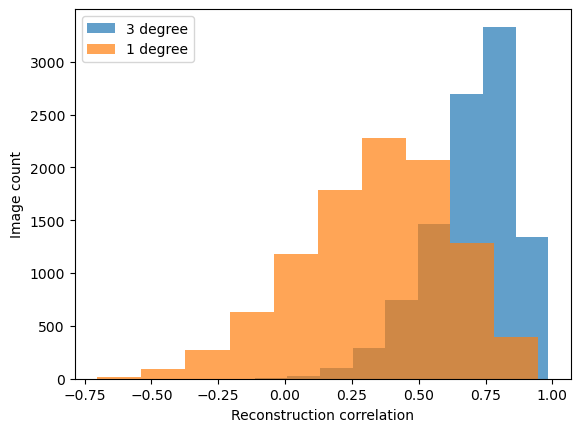

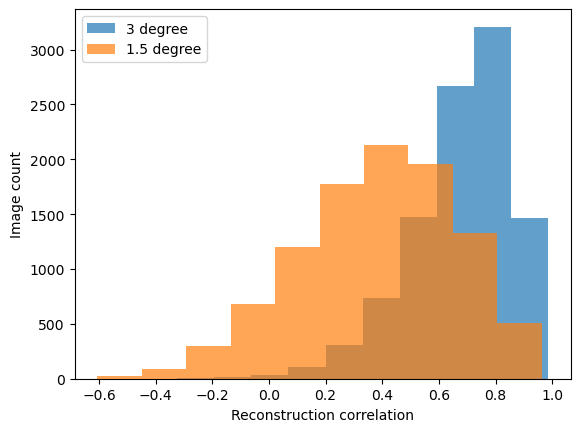

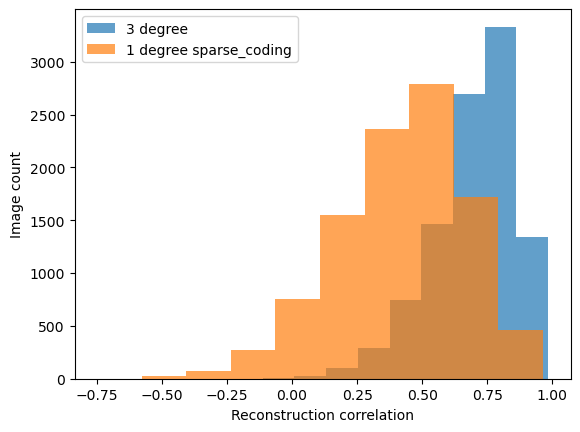

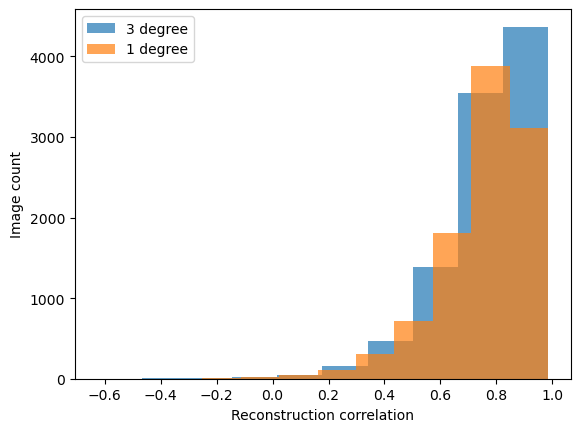

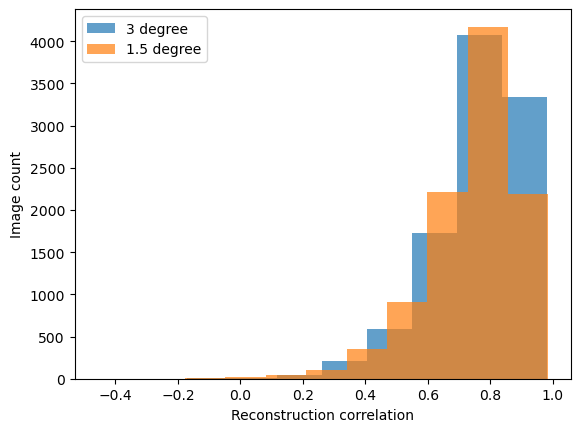

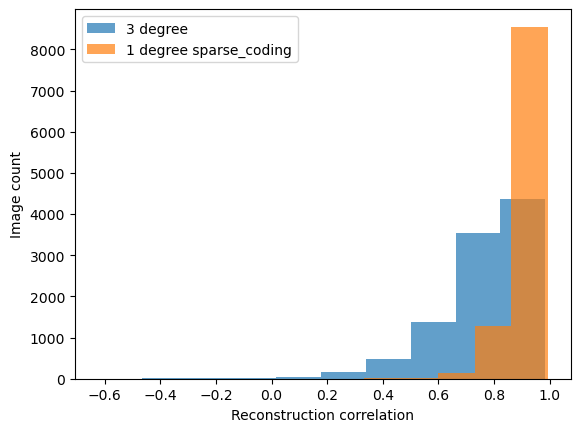

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(o_c, alpha = 0.7, label='3 degree')
plt.hist(o_c_15,alpha = 0.7, label='1 degree')
plt.ylabel('Image count')
plt.xlabel('Reconstruction correlation')
plt.legend()
plt.savefig("bar_chart_corr_performance/outer_corr_size_50_16")

import matplotlib.pyplot as plt
plt.figure()
plt.hist(o_c1, alpha = 0.7, label='3 degree')
plt.hist(o_c_22,alpha = 0.7, label='1.5 degree')
plt.ylabel('Image count')
plt.xlabel('Reconstruction correlation')
plt.legend()
plt.savefig("bar_chart_corr_performance/outer_corr_size_50_22")

import matplotlib.pyplot as plt
plt.figure()
plt.hist(o_c, alpha = 0.7, label='3 degree')
plt.hist(o_c_s,alpha = 0.7, label='1 degree sparse_coding')
plt.ylabel('Image count')
plt.xlabel('Reconstruction correlation')
plt.legend()
plt.savefig("bar_chart_corr_performance/outer_corr_size_50_sparse")

import matplotlib.pyplot as plt
plt.figure()
plt.hist(i_c, alpha = 0.7, label='3 degree')
plt.hist(i_c_15,alpha = 0.7, label='1 degree')
plt.ylabel('Image count')
plt.xlabel('Reconstruction correlation')
plt.legend()
plt.savefig("bar_chart_corr_performance/inner_corr_size_50_16")

import matplotlib.pyplot as plt
plt.figure()
plt.hist(i_c1, alpha = 0.7, label='3 degree')
plt.hist(i_c_22,alpha = 0.7, label='1.5 degree')
plt.ylabel('Image count')
plt.xlabel('Reconstruction correlation')
plt.legend()
plt.savefig("bar_chart_corr_performance/inner_corr_size_50_22")

import matplotlib.pyplot as plt
plt.figure()
plt.hist(i_c, alpha = 0.7, label='3 degree')
plt.hist(i_c_s,alpha = 0.7, label='1 degree sparse_coding')
plt.ylabel('Image count')
plt.xlabel('Reconstruction correlation')
plt.legend()
plt.savefig("bar_chart_corr_performance/inner_corr_size_50_sparse")

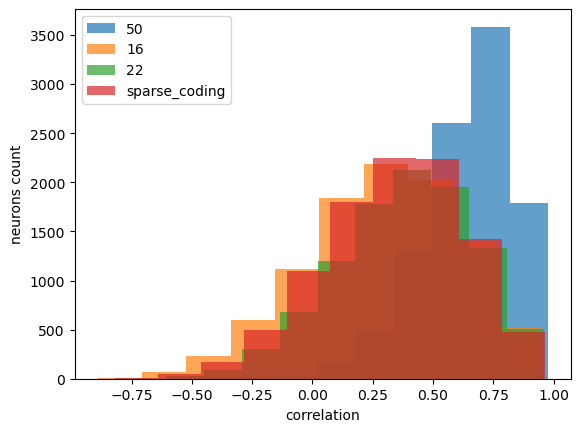

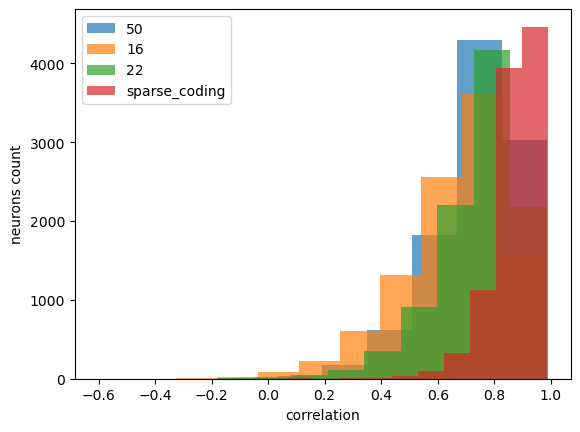

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(o_c, alpha = 0.7, label='50')
plt.hist(o_c_15,alpha = 0.7, label='16')
plt.hist(o_c_22,alpha = 0.7, label='22')
plt.hist(o_c_s,alpha = 0.7, label='sparse_coding')
plt.ylabel('neurons count')
plt.xlabel('correlation')
plt.legend()
plt.savefig("outer_corr_size_22")

plt.figure()
plt.hist(i_c, alpha = 0.7,label='50')
plt.hist(i_c_15, alpha = 0.7,label='16')
plt.hist(i_c_22,alpha = 0.7, label='22')
plt.hist(i_c_s,alpha = 0.7, label='sparse_coding')
plt.ylabel('neurons count')
plt.xlabel('correlation')
plt.legend()
plt.savefig("inner_corr_size_22")

In [13]:
mse = np.average(mse, axis=(1,2,3))
mse_15 = np.average(mse_15, axis=(1,2,3))
mse_22 = np.average(mse_22, axis=(1,2,3))

In [14]:
print(np.average(mse))
print(np.average(mse_15))
print(np.average(mse_22))

0.06796965
0.16327208
0.13623653


(array([2812., 3984., 1951.,  730.,  292.,  137.,   50.,   32.,    8.,
           4.]),
 array([0.0062694 , 0.09551504, 0.18476067, 0.27400634, 0.36325195,
        0.4524976 , 0.5417432 , 0.6309889 , 0.7202345 , 0.8094802 ,
        0.8987258 ], dtype=float32),
 <BarContainer object of 10 artists>)

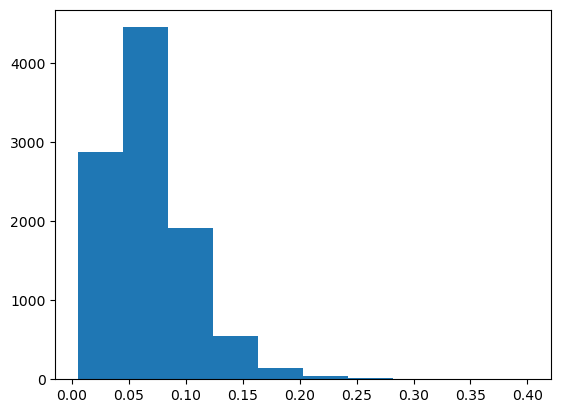

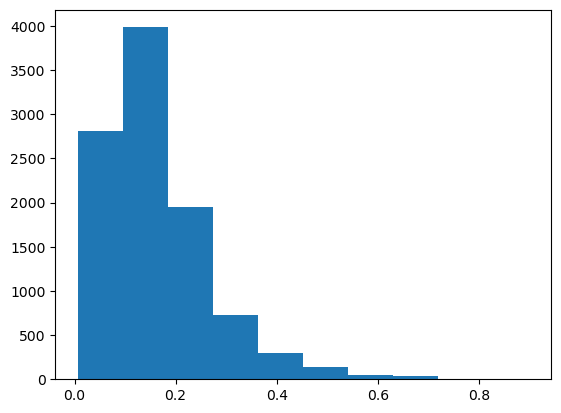

In [15]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(mse)
plt.figure()
plt.hist(mse_15)

In [16]:
selected_imgs = [50, 85, 98, 149, 188, 198, 245, 315, 331, 429]
img_list = []
for i in selected_imgs                                             :
    origin, sample_full = testset_rsp.__getitem__(i)
    recon = prednet(sample_full.to(device)).detach().cpu().numpy()


    _, sample_16 = testset_rsp_15.__getitem__(i)
    sample_16.to(device)
    recon_16 = prednet_15(sample_16.to(device)).detach().cpu().numpy()

    _, sample_22 = testset_rsp_22.__getitem__(i)
    sample_22.to(device)
    recon_22 = prednet_15(sample_22.to(device)).detach().cpu().numpy()

    sample = torch.reshape(origin, (1,1,50,50)).to(device)
    recon_s = prednet_s(process_img_batch(sample, templates)).detach().cpu().numpy()


    origin = origin.numpy()
    all_imgs = np.array([np.reshape(origin,(50,50)), np.reshape(recon,(50,50)), np.reshape(recon_16,(50,50)),np.reshape(recon_22,(50,50)), np.reshape(recon_s,(50,50))])
    img_list.append(all_imgs)


In [17]:
img_list = np.transpose(np.array(img_list), (1,0,2,3))

In [22]:
import imshowtools
from cv2 import imwrite

def show_imgs_in1Page(img_matrix,cmap='gray',showsize=(10,10),columns=None,rows=None,padding=False,title=None):
    '''
    shape: (numbers,H,W)
    '''

    assert len(img_matrix.shape)==3
    assert isinstance(showsize,tuple)

    return imshowtools.imshow(*img_matrix,cmap=cmap,size=showsize,columns=columns,rows=rows,padding=padding,title=title,return_image=True)


img = show_imgs_in1Page(np.reshape(img_list,(50,50,50)), cmap='gray',showsize=(50,50),columns=10,rows=5)

In [23]:
imwrite("sample_recon_img_1.png", img)

True

In [31]:
prednet_real = reconstruct_CNN(299)
prednet_real.load_state_dict(torch.load('recon_model_tang_data'))
prednet_real.eval().to(device)

reconstruct_CNN(
  (final_layer): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), dilation=(5, 5), output_padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
  )
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ConvTranspo

In [32]:
from modeling.train_utils import  array_to_dataloader
site = 'm2s1'
train_x = np.load('../data/Processed_Tang_data/all_sites_data_prepared/pics_data/train_img_'+site+'.npy')
val_x = np.load('../data/Processed_Tang_data/all_sites_data_prepared/pics_data/val_img_'+site+'.npy')
train_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/trainRsp_'+site+'.npy')
val_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/valRsp_'+site+'.npy')
train_x = np.transpose(train_x, (0, 3, 1, 2))
val_x = np.transpose(val_x, (0, 3, 1, 2))
train_loader = array_to_dataloader(train_x, train_y, batch_size=1024, shuffle=True)
val_loader = array_to_dataloader(val_x, val_y, batch_size=1024)
criterion = torch.nn.MSELoss()
device = 'cuda'

In [33]:
with torch.no_grad():
    val_losses = []
    prednet_real.to(device)
    for i, (x, y) in enumerate(val_loader):
        x = x.float().to(device)
        y = y.float().to(device)
        recon = prednet_real(y)
        loss = criterion(recon, x)

        val_losses.append(loss.item())
    avg_loss = np.mean(val_losses)
    print(avg_loss)

0.018942605704069138


In [27]:
sample = torch.tensor(val_y[:20], dtype=torch.float).to(device)
recon = prednet_real(sample).detach().cpu().numpy()
origin = val_x[:20]
for i, (r_img, img) in enumerate(zip(recon, origin)):
    r_img = np.reshape(r_img, (50, 50))
    img = np.reshape(img, (50, 50))
    print("newimg")
    plt.imsave(f'recon_tang/recon_{i}.png',r_img, cmap='gray')
    plt.show()
    plt.imsave(f'recon_tang/origin_{i}.png',img, cmap='gray')
    plt.show()

newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
newimg
